In [1]:
!pip install pennylane dm-haiku --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import haiku as hk
import jax
import optax
from sklearn.metrics import accuracy_score
import pennylane as qml
from pennylane import numpy as np
import jax
from jax import random
import haiku as hk

# Load data
x_train = pd.read_excel("x_train.xlsx")
y_train = pd.read_excel("y_train.xlsx")
x_test = pd.read_excel("x_test.xlsx")
y_test = pd.read_excel("y_test.xlsx")

n_qubits = 8
epochs = 500
batch_size = 32
num_layers = 8

num_batches = len(x_train) // batch_size
dev = qml.device("default.qubit", wires=n_qubits)

def quantum_layer(weights):
    qml.templates.AngleEmbedding(weights[:, 0], rotation="Y", wires=range(n_qubits))
    qml.templates.AngleEmbedding(weights[:, 1], rotation="Z", wires=range(n_qubits))
    for i in range(8):
        qml.CNOT(wires=[i, (i + 1) % 8])

@qml.qnode(dev, interface="jax")
def quantum_circuit(x, circuit_weights):
    for weights in circuit_weights:
        qml.templates.AngleEmbedding(x, wires=range(n_qubits))
        quantum_layer(weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


@hk.without_apply_rng
@hk.transform
def forward(x):
    x = jax.nn.tanh(hk.Linear(8)(x))
    W = hk.get_parameter(
        "W", (num_layers, 8, 3), init=hk.initializers.RandomNormal(stddev=0.25)
    )
    x = jax.vmap(quantum_circuit, in_axes=(0, None))(x, W)
    s = hk.get_parameter("s", (8,), init=hk.initializers.Constant(1.0))
    x = hk.Linear(1)(x)
    return x

@hk.without_apply_rng
@hk.transform
def cforward(x):
    nn =hk.Sequential([hk.Linear(10), 
                       jax.nn.relu,
                       hk.Linear(10), 
                       jax.nn.relu,
                       hk.Linear(1)])
    return x

seed = 123
rng = jax.random.PRNGKey(seed)
params = forward.init(rng, x_train.values)
opt = optax.radam(learning_rate=5e-4)
opt_state = opt.init(params)


# Training loop
def loss_fn(params, x, y):
    pred = forward.apply(params, x)
    loss = optax.sigmoid_binary_cross_entropy(pred, y).mean()
    return loss


@jax.jit
def update(params, opt_state, x, y):
    loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss

loss_list = []
test_acc = []
for epoch in range(epochs):
    # Shuffle the training data
    shuffled_indices = np.random.permutation(len(x_train))
    x_train_shuffled = x_train.values[shuffled_indices]
    y_train_shuffled = y_train.values[shuffled_indices]

    # Training
    epoch_loss = 0
    for batch_idx in range(num_batches):
        start = batch_idx * batch_size
        end = start + batch_size

        x_batch = x_train_shuffled[start:end]
        y_batch = y_train_shuffled[start:end]

        params, opt_state, batch_loss = update(params, opt_state, x_batch, y_batch)
        epoch_loss += batch_loss

    epoch_loss /= num_batches
    loss_list.append(epoch_loss)

    # Testing
    y_pred = forward.apply(params, x_test.values)
    y_pred_labels = (y_pred > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test, y_pred_labels)
    print(
        f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}"
    )  # ", Test Accuracy: {test_accuracy:.4f}")
    test_acc.append(test_accuracy)

# Testing
y_pred = forward.apply(params, x_test.values)
y_pred_labels = (y_pred > 0.5).astype(int)
test_accuracy = accuracy_score(y_test.values, y_pred_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Epoch 1, Loss: 0.6973
Epoch 2, Loss: 0.6968
Epoch 3, Loss: 0.6962
Epoch 4, Loss: 0.6953
Epoch 5, Loss: 0.6947
Epoch 6, Loss: 0.6937
Epoch 7, Loss: 0.6929
Epoch 8, Loss: 0.6922
Epoch 9, Loss: 0.6918
Epoch 10, Loss: 0.6908
Epoch 11, Loss: 0.6899
Epoch 12, Loss: 0.6878
Epoch 13, Loss: 0.6859
Epoch 14, Loss: 0.6845
Epoch 15, Loss: 0.6834
Epoch 16, Loss: 0.6819
Epoch 17, Loss: 0.6804
Epoch 18, Loss: 0.6783
Epoch 19, Loss: 0.6768
Epoch 20, Loss: 0.6753
Epoch 21, Loss: 0.6747
Epoch 22, Loss: 0.6724
Epoch 23, Loss: 0.6711
Epoch 24, Loss: 0.6699
Epoch 25, Loss: 0.6686
Epoch 26, Loss: 0.6659
Epoch 27, Loss: 0.6636
Epoch 28, Loss: 0.6528
Epoch 29, Loss: 0.6489
Epoch 30, Loss: 0.6482
Epoch 31, Loss: 0.6420
Epoch 32, Loss: 0.6408
Epoch 33, Loss: 0.6362
Epoch 34, Loss: 0.6350
Epoch 35, Loss: 0.6314
Epoch 36, Loss: 0.6303
Epoch 37, Loss: 0.6291
Epoch 38, Loss: 0.6285
Epoch 39, Loss: 0.6259
Epoch 40, Loss: 0.6189
Epoch 41, Loss: 0.6189
Epoch 42, Loss: 0.6201
Epoch 43, Loss: 0.6115
Epoch 44, Loss: 0.60

In [7]:
import matplotlib.pyplot as plt

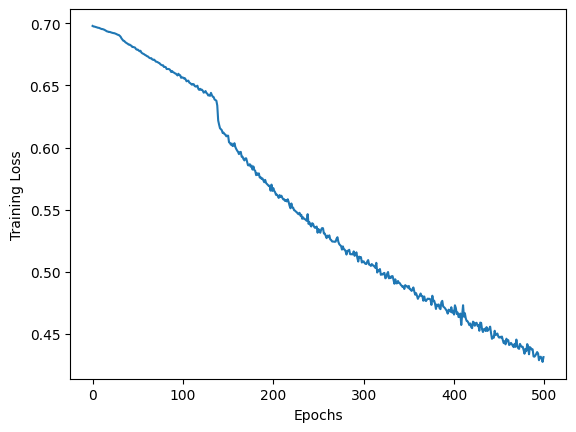

In [8]:
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.savefig('loss_curve.png')